ref:https://colab.research.google.com/github/yfletberliac/rlss-2019/blob/master/labs/DRL.01.REINFORCE%2BA2C.ipynb#scrollTo=_5pS7cRyyFhC  
https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On-Second-Edition/blob/master/Chapter12/02_pong_a2c.py

In [1]:
from enum import Enum
from typing import List
from collections import deque
from copy import copy
import random
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import torch.nn.utils as nn_utils
import numpy as np

In [3]:
class JankenHand(Enum):
    GUU = 0
    CHOKI = 1
    PAA = 2

    @staticmethod
    def idx2hand(idx: int):
        for hand in JankenHand:
            if idx == hand.value:
                return hand
        raise ValueError(f'not supported hand index {idx}')

In [4]:
class JankenResult(Enum):
    YOUR_WIN = 2
    DRAW = 1
    YOUR_LOSE = 0

In [5]:
class Oponent:
    """グー -> チョキ -> パーを繰り返す相手"""

    def __init__(self):
        self._n = 0
    
    def hand(self) -> JankenHand:
        hand = JankenHand.idx2hand(self._n%3)
        self._n += 1
        return hand

    def reset(self) -> None:
        self._n = 0

In [6]:
oponent = Oponent()

In [7]:
for i in range(7):
    print(oponent.hand())

JankenHand.GUU
JankenHand.CHOKI
JankenHand.PAA
JankenHand.GUU
JankenHand.CHOKI
JankenHand.PAA
JankenHand.GUU


In [8]:
class JankenEnv:

    STATE_DIM = 6

    def __init__(self):
        self._oponent = Oponent()
        self._state = self.reset()

    def step(self, action: JankenHand):
        oponent_hand = self._oponent.hand()
        self._state.append(oponent_hand)
        if (action == JankenHand.GUU and oponent_hand == JankenHand.CHOKI) or \
            (action == JankenHand.CHOKI and oponent_hand == JankenHand.PAA) or \
            (action == JankenHand.PAA and oponent_hand == JankenHand.GUU):
            result = JankenResult.YOUR_WIN
        elif (action == JankenHand.GUU and oponent_hand == JankenHand.PAA) or \
            (action == JankenHand.CHOKI and oponent_hand == JankenHand.GUU) or \
            (action == JankenHand.PAA and oponent_hand == JankenHand.CHOKI):
            result = JankenResult.YOUR_LOSE
        else:
            result = JankenResult.DRAW
        reward = result.value - 0.1*len(self._results)  # 長くかかるとマイナスのペナルティ
        self._results.append(result)
        done = False
        if len(self._results) >= 3:
            # 3回連続で勝利したらdone
            done = all([res==JankenResult.YOUR_WIN for res in self._results[-3:]])
            if done:
                reward = 50 / (len(self._results)-3+1)**1  # 長くかかるほど最終報酬は小さく
        next_state = copy(self._state)
        return next_state, reward, done

    def reset(self) -> deque:
        self._state = deque([JankenHand.GUU]*JankenEnv.STATE_DIM, maxlen=JankenEnv.STATE_DIM)
        self._oponent.reset()
        self._results = []
        return self._state

    @property
    def results(self) -> List[JankenResult]:
        return self._results

In [9]:
janken_env = JankenEnv()

In [10]:
janken_env.reset()
for i in range(50):
    next_state, reward, done = janken_env.step(action=JankenHand.idx2hand(random.randint(0, 2)))
    print(f'{next_state} : {reward} : {done}')

deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>], maxlen=6) : 2.0 : False
deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>], maxlen=6) : 0.9 : False
deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>], maxlen=6) : 0.8 : False
deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>, <JankenHand.GUU: 0>], maxlen=6) : 0.7 : False
deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>], maxlen=6) : 0.6 : False
deque([<JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>], maxlen=6) : 0.5 : False
deque([<JankenHand.CHOKI: 1>, <JankenH

In [11]:
class ActorNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        # out = F.softmax(self.fc3(out), dim=-1)
        out = self.fc3(out)
        return out
    
    def select_action(self, x):
        return torch.multinomial(self(x), 1).detach().numpy()

In [55]:
class ValueNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [59]:
OBSERVATION_SPACE_DIM = 6
HIDDEN_DIM = 16
ACTION_DIM = 3
LEARNING_RATE = 0.005

In [60]:
value_network = ValueNetwork(OBSERVATION_SPACE_DIM, HIDDEN_DIM, 1)
actor_network = ActorNetwork(OBSERVATION_SPACE_DIM, HIDDEN_DIM, ACTION_DIM)

In [61]:
value_actor_optimizer = torch.optim.Adam(list(value_network.parameters())+list(actor_network.parameters()), lr=LEARNING_RATE, eps=1e-3)

In [62]:
gamma = 0.99
ENTROPY_BETA = 0.01
returns = deque(maxlen=100)
BATCH_SIZE = 256
N_EPISODES = 10000
CLIP_GRAD = 0.1

In [63]:
np.random.randint(0, 2)

0

In [64]:
results_episodes = []
n_episode = 0

# for episode in range(N_EPISODES):
while True:
    rewards = []
    actions = []
    states  = []
    values = []
    dones = []
    # reset environment
    state = janken_env.reset()
    state = [s.value for s in state]
    for n in range(BATCH_SIZE):

        value = value_network(torch.tensor(state, dtype=torch.float)).detach().numpy()[0]

        # calculate probabilities of taking each action
        logits_v = actor_network(torch.tensor(state).unsqueeze(0).float())
        probs = F.softmax(logits_v, dim=1)
        # sample an action from that set of probs
        sampler = Categorical(probs)
        action = sampler.sample()

        # use that action in the environment
        new_state, reward, done = janken_env.step(JankenHand.idx2hand(action.item()))
        new_state = [s.value for s in new_state]
        # store state, action and reward
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        values.append(value)
        dones.append(done)

        state = new_state
        if done:
            results_episodes.append(copy(janken_env.results))
            state = janken_env.reset()
            state = [s.value for s in state]

    # If our epiosde didn't end on the last step we need to compute the value for the last state
    if dones[-1]:
        next_value = 0
    else:
        next_value = value_network(torch.tensor(state, dtype=torch.float)).detach().numpy()[0]

    n_episode += sum(dones)

    rewards = np.array(rewards)

    # R = torch.tensor([np.sum(rewards[i:]*(gamma**np.array(range(i, len(rewards))))) for i in range(len(rewards))])
    R = np.append(np.zeros_like(rewards), [next_value], axis=0)
    for t in reversed(range(rewards.shape[0])):
        R[t] = rewards[t] + gamma * R[t + 1] * (1 - int(dones[t]))
    R = torch.tensor(R[:-1])

    states = torch.tensor(states).float()
    actions = torch.tensor(actions)

    value_v = value_network(states)
    loss_value_v = F.mse_loss(value_v.squeeze(-1).float(), R.float()).float()

    adv_v = R - value_v.squeeze(-1).detach()
    # calculate gradient
    logits_v = actor_network(states).float()
    probs = F.softmax(logits_v, dim=1)
    log_prob_v = F.log_softmax(logits_v, dim=1)

    log_prob_actions_v = adv_v * log_prob_v[range(BATCH_SIZE), actions]
    loss_policy_v = -log_prob_actions_v.mean()

    entropy_loss_v = ENTROPY_BETA * (probs * log_prob_v).sum(dim=1).mean()

    loss_policy_v.backward(retain_graph=True)
    grads = np.concatenate([p.grad.data.cpu().numpy().flatten()
                        for p in list(value_network.parameters())+list(actor_network.parameters())
                        if p.grad is not None])

    # apply entropy and value gradients
    loss_v = entropy_loss_v + loss_value_v
    loss_v.backward()
    nn_utils.clip_grad_norm_(list(value_network.parameters())+list(actor_network.parameters()), CLIP_GRAD)
    value_actor_optimizer.step()
    # get full loss
    loss_v += loss_policy_v

    # calculate average return and print it out
    returns.append(np.sum(rewards))
    if np.random.randint(0, 10) % 10 == 0:
        print("Episode: {:6d}\tAvg. Return: {:6.2f}".format(n_episode, np.mean(returns)))

    if n_episode >= N_EPISODES:
        break

Episode:     36	Avg. Return: -673.84
Episode:     96	Avg. Return: -682.48
Episode:    127	Avg. Return: -694.00
Episode:    149	Avg. Return: -684.31
Episode:    168	Avg. Return: -659.51
Episode:    209	Avg. Return: -607.42
Episode:    219	Avg. Return: -591.26
Episode:    306	Avg. Return: -566.79
Episode:    362	Avg. Return: -550.07
Episode:    545	Avg. Return: -515.03
Episode:    588	Avg. Return: -511.66
Episode:    611	Avg. Return: -509.13
Episode:    616	Avg. Return: -509.60
Episode:    801	Avg. Return: -446.99
Episode:    810	Avg. Return: -443.81
Episode:    847	Avg. Return: -445.17
Episode:    871	Avg. Return: -446.65
Episode:    973	Avg. Return: -439.98
Episode:   1123	Avg. Return: -408.46
Episode:   1133	Avg. Return: -407.19
Episode:   1297	Avg. Return: -376.07
Episode:   1388	Avg. Return: -368.92
Episode:   1392	Avg. Return: -370.31
Episode:   1443	Avg. Return: -346.12
Episode:   1537	Avg. Return: -339.80
Episode:   1560	Avg. Return: -349.49
Episode:   1577	Avg. Return: -347.56
E

In [68]:
# エピソード1
results_episodes[0]

[<JankenResult.DRAW: 1>,
 <JankenResult.DRAW: 1>,
 <JankenResult.YOUR_LOSE: 0>,
 <JankenResult.YOUR_LOSE: 0>,
 <JankenResult.DRAW: 1>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.DRAW: 1>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.DRAW: 1>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.YOUR_WIN: 2>]

In [71]:
# エピソード2
results_episodes[1]

[<JankenResult.YOUR_LOSE: 0>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.YOUR_LOSE: 0>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.YOUR_LOSE: 0>,
 <JankenResult.DRAW: 1>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.YOUR_LOSE: 0>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.DRAW: 1>,
 <JankenResult.DRAW: 1>,
 <JankenResult.YOUR_LOSE: 0>,
 <JankenResult.DRAW: 1>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.DRAW: 1>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.DRAW: 1>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.DRAW: 1>,
 <JankenResult.YOUR_LOSE: 0>,
 <JankenResult.YOUR_LOSE: 0>,
 <JankenResult.DRAW: 1>,
 <JankenResult.DRAW: 1>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.YOUR_LOSE: 0>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.DRAW: 1>,
 <JankenResult.YOUR_LOSE: 0>,
 <JankenResult.DRAW: 1>,
 <JankenResult.DRAW: 1>,
 <JankenResult.DRAW: 1>,
 <JankenResult.YOUR_LOSE: 0>

In [72]:
# エピソード10000
results_episodes[-1]

[<JankenResult.DRAW: 1>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.YOUR_WIN: 2>]

In [73]:
# エピソード9999
results_episodes[-2]

[<JankenResult.DRAW: 1>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.YOUR_WIN: 2>,
 <JankenResult.YOUR_WIN: 2>]

Text(0, 0.5, 'step length taken until done')

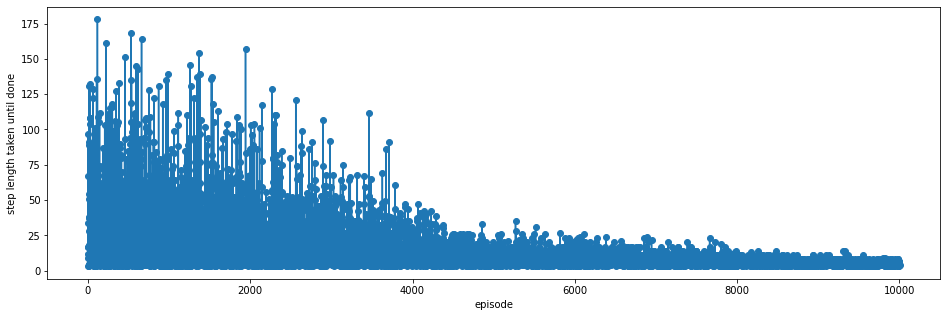

In [70]:
plt.figure(figsize=(16, 5))
plt.plot([len(re) for re in results_episodes], marker='o')
plt.xlabel('episode')
plt.ylabel('step length taken until done')

41.5


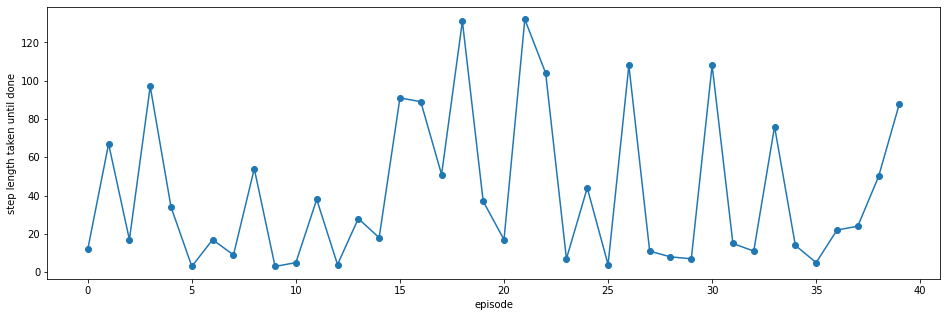

In [80]:
# 最初の40エピソード
plt.figure(figsize=(16, 5))
plt.plot([len(re) for re in results_episodes[:40]], marker='o')
plt.xlabel('episode')
plt.ylabel('step length taken until done')

print(np.mean([len(re) for re in results_episodes[:40]]))

4.975


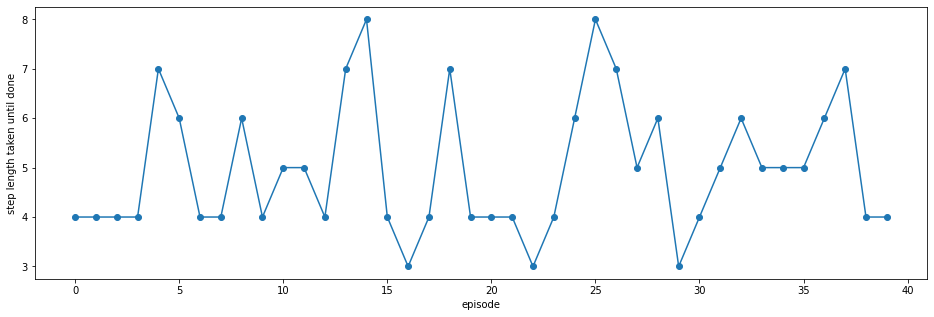

In [79]:
# 最後の40エピソード
plt.figure(figsize=(16, 5))
plt.plot([len(re) for re in results_episodes[-40:]], marker='o')
plt.xlabel('episode')
plt.ylabel('step length taken until done')

print(np.mean([len(re) for re in results_episodes[-40:]]))